In [1]:
import sys 
sys.path.append('../')

import numpy as np
np.random.seed(314159)
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import parameter_tuning
import plot_boundary
import analysis_functions as af

from metric_functions import compute_accuracy, compute_auc_from_scores
from kernel_SVM_functions import rbf_kernel
from classifiers import QUBOSoftMarginClassifier, SoftMarginKernelClassifier


In [2]:
filename = 'versicolor-virginica'
train_size = 0.2

data = pd.read_csv(f'../iris_data/{filename}.csv').to_numpy()

X = data[:, 1: -1]
t = data[:, -1]
#iris_setosa will be 1, iris-versicolor will be -1
t[t == 'Iris-versicolor'] = 1
t[t == 'Iris-virginica'] = -1
t = t.astype('float')

X_train, X_test, t_train, t_test = train_test_split(X, t, train_size = train_size, shuffle = True, stratify = t)
t_train = t_train.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)

## Tuning parameters for qSVM

In [33]:
B_values = [2, 3, 5, 10]
K_values = [2, 3, 4]
R_values = [0, 1, 3, 5]
gamma_values = [2 ** i for i in range(-3, 3)]
kernel_func = rbf_kernel
#This results in a matrix with shape (4, 2, 4, 7)

run = False

if run:

    accuracy_results, auroc_results, times = parameter_tuning.tune_qsvm_parameters(X_train, t_train, B_values, K_values, R_values, gamma_values, kernel_func)

    np.save(f'../results/QUBO-{filename}-accuracy', accuracy_results)
    np.save(f'../results/QUBO-{filename}-auroc', auroc_results)
    np.save(f'../results/QUBO-{filename}-time', times)

## Tuning parameters for kSVM

In [34]:
C_values = [2 ** i for i in range(0, 7)]
gamma_values = [2 **i for i in range(-3, 3)]
kernel_func = rbf_kernel

run = False

if run:

    accuracy_results, auroc_results, times = parameter_tuning.tune_csvm_parameters(X_train, t_train, C_values, gamma_values, kernel_func)

    np.save(f'../results/kSVM-{filename}-accuracy', accuracy_results)
    np.save(f'../results/kSVM-{filename}-auroc', auroc_results)
    np.save(f'../results/kSVM-{filename}-time', times)

## Get data from files

In [36]:
qSVM_accuracy = np.load(f'../results/QUBO-{filename}-accuracy.npy')
qSVM_auroc = np.load(f'../results/QUBO-{filename}-auroc.npy')

cSVM_accuracy = np.load(f'../results/kSVM-{filename}-accuracy.npy')
cSVM_auroc = np.load(f'../results/kSVM-{filename}-auroc.npy')

In [37]:
print(qSVM_accuracy.shape, cSVM_accuracy.shape)

(4, 3, 4, 6) (7, 6)


## Best models QUBOSVM
Finding best models based on Accuracy and then plotting them

In [40]:
print(f'cSVM best accuracy {np.max(cSVM_accuracy[:, 1: ])} \n cSVM best auroc {np.max(cSVM_auroc[:, 1: ])} \n')
print(f'qSVM best accuracy {np.max(qSVM_accuracy)} \n qSVM best auroc {np.max(qSVM_auroc)} \n')

cSVM best accuracy 1.0 
 cSVM best auroc 1.0 

qSVM best accuracy 0.8400000000000001 
 qSVM best auroc 0.9800000000000001 



In [41]:
val_list = [B_values, K_values, R_values, gamma_values]
model_indices = af.find_best(qSVM_auroc, 20)
top_models = [af.get_params(val_list, model_indices[i]) for i in range(len(model_indices))]

#top_model_acc = [qSVM_accuracy[index] for index in model_indices]
#top_model_auc = [qSVM_auroc[index] for index in model_indices]

In [42]:
tp_acc_mean = []
tp_acc_std = []

tp_auc_mean = []
tp_auc_std = []

kernel_func = rbf_kernel
n = 50

#Averaging the accuracy and auc for each parameter set over 50 models
for i, model_parameters in enumerate(top_models):

    accuracy = []
    auroc = []

    for j in range(n):
        
        qsmc = QUBOSoftMarginClassifier(model_parameters[0], model_parameters[1], model_parameters[2], kernel_func, model_parameters[3])
        qsmc = qsmc.make_QUBO_problem(X_train, t_train).fit(X_train, t_train)
        scores = qsmc.decision_function(X_test)
        preds = qsmc.predict(X_test)
        
        accuracy.append(compute_accuracy(preds, t_test))
        auroc.append(compute_auc_from_scores(scores, t_test))

    tp_acc_mean.append(np.mean(accuracy))
    tp_acc_std.append(np.std(accuracy))

    tp_auc_mean.append(np.mean(auroc))
    tp_auc_std.append(np.std(auroc))

In [43]:
#Models ordered by AUROC score.
np.array(top_models)[np.argsort(-np.array(tp_auc_mean))]

array([[ 2.   ,  4.   ,  0.   ,  0.125],
       [ 2.   ,  4.   ,  0.   ,  0.5  ],
       [ 2.   ,  4.   ,  0.   ,  0.25 ],
       [ 2.   ,  3.   ,  0.   ,  0.5  ],
       [ 3.   ,  4.   ,  0.   ,  0.125],
       [ 2.   ,  3.   ,  0.   ,  1.   ],
       [ 3.   ,  3.   ,  0.   ,  0.5  ],
       [ 3.   ,  2.   ,  0.   ,  0.125],
       [ 2.   ,  4.   ,  3.   ,  1.   ],
       [ 2.   ,  3.   ,  3.   ,  0.5  ],
       [ 2.   ,  4.   ,  1.   ,  1.   ],
       [ 2.   ,  4.   ,  3.   ,  0.25 ],
       [ 2.   ,  4.   ,  1.   ,  0.125],
       [ 2.   ,  4.   ,  3.   ,  0.5  ],
       [ 2.   ,  4.   ,  5.   ,  0.25 ],
       [ 2.   ,  4.   ,  1.   ,  0.5  ],
       [ 3.   ,  4.   ,  3.   ,  0.125],
       [ 3.   ,  3.   ,  1.   ,  0.125],
       [10.   ,  4.   ,  0.   ,  0.25 ],
       [ 5.   ,  4.   ,  5.   ,  0.125]])

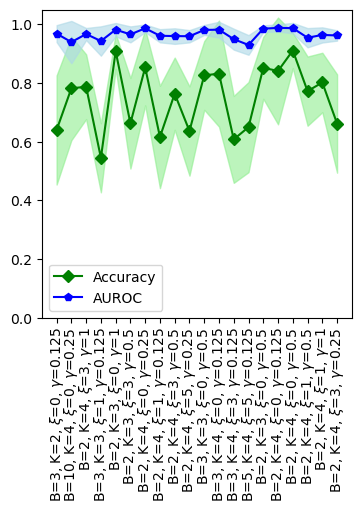

In [44]:
fig, ax = plt.subplots(figsize = (4, 4))

af.plot_top_models(top_models, np.array([tp_acc_mean, tp_acc_std]), np.array([tp_auc_mean, tp_auc_std]), fig = fig, ax = ax)
plt.savefig('../plots/virgi-versi-quboplot.png', dpi = 256)
plt.show()

In [55]:
sorted(tp_auc_mean, reverse = True)

[0.9875375,
 0.9868124999999999,
 0.9861999999999999,
 0.9849624999999999,
 0.9815374999999998,
 0.9815124999999999,
 0.9805499999999999,
 0.9680374999999999,
 0.9666,
 0.9654499999999999,
 0.9636125,
 0.96175,
 0.960775,
 0.9596375,
 0.9591249999999999,
 0.954075,
 0.949125,
 0.94285,
 0.9391624999999999,
 0.9294625000000001]

## Best cSVM

In [14]:
cSVM_auroc

array([[0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
       [0.9, 0.9, 0.9, 0.9, 1. , 0.9],
       [0.8, 0.9, 1. , 1. , 0.9, 0.7],
       [0.9, 1. , 1. , 0.9, 0.5, 0.7],
       [1. , 1. , 1. , 0.8, 0.5, 0.7],
       [1. , 1. , 0.7, 0.6, 0.5, 0.7],
       [1. , 0.7, 0.8, 0.6, 0.5, 0.7]])

In [46]:
C_values

[1, 2, 4, 8, 16, 32, 64]

In [47]:
clf = SoftMarginKernelClassifier(32, kernel_func, 2)
clf = clf.fit(X_train, t_train)

scores = clf.decision_function(X_test)
preds = clf.predict(X_test)

auc = compute_auc_from_scores(scores, t_test)
acc = compute_accuracy(preds, t_test)
print(auc, acc)

0.9368749999999999 0.9125


## cSVM boundary plot

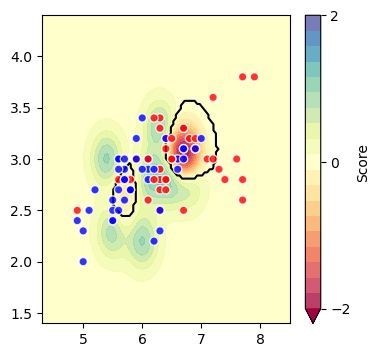

In [15]:
#Showing the decision boundary between petal length and petal width -- which divides the data really well. 
dimensions = [0, 1]
clf = SoftMarginKernelClassifier(1, kernel_func, 16)
clf = clf.fit(X_train, t_train)
scores = clf.decision_function(X_test)
preds = clf.predict(X_test)
c_prob_dist = clf.predict_proba(X_test)

clf.support_vectors = clf.support_vectors[:, dimensions]
clf.alphas = clf.alphas[dimensions]
plot_X_test = X_test[:, dimensions]
plot_t_test = t_test

plot_boundary.plot(plot_X_test, plot_t_test, clf, contour_func = 'decision_function', colorbar = True)

## qSVM boundary plot

/Users/isaaccopson/Desktop/Research Project/ResearchProjectRepo/Main/DataAnalysis/../plot_boundary.py:52: UserWarning: No contour levels were found within the data range.
  cs = ax.contour(xx, yy, prediction, [0], cmap = 'bone')


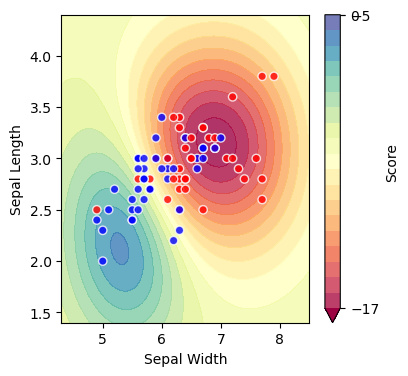

In [16]:
#Showing the decision boundary between petal length and petal width -- which divides the data really well. 
clf = QUBOSoftMarginClassifier(2, 3, 5, kernel_func, 1)
clf = clf.make_QUBO_problem(X_train, t_train).fit(X_train, t_train)
scores = clf.decision_function(X_test)
preds = clf.predict(X_test)
q_prob_dist = clf.predict_proba(X_test)

clf.support_vectors = clf.support_vectors[:, dimensions]
clf.alphas = clf.alphas[dimensions]

fig, ax = plt.subplots(figsize = (4, 4))

plot_boundary.plot(plot_X_test, plot_t_test, clf, contour_func = 'decision_function', colorbar = True, fig = fig, ax = ax)
ax.set_ylabel('Sepal Length')
ax.set_xlabel('Sepal Width')
plt.show()

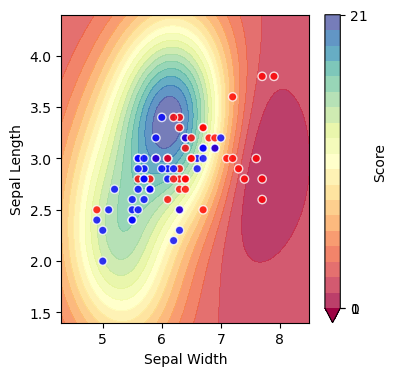

In [17]:
#Showing the decision boundary between petal length and petal width -- which divides the data really well. 
dimensions = [0, 1]
clf = QUBOSoftMarginClassifier(5, 3, 0, kernel_func, 1)
clf = clf.make_QUBO_problem(X_train, t_train).fit(X_train, t_train)
scores = clf.decision_function(X_test)
preds = clf.predict(X_test)
q_prob_dist = clf.predict_proba(X_test)

clf.support_vectors = clf.support_vectors[:, dimensions]
clf.alphas = clf.alphas[dimensions]

fig, ax = plt.subplots(figsize = (4, 4))

plot_boundary.plot(plot_X_test, plot_t_test, clf, contour_func = 'decision_function', colorbar = True, fig = fig, ax = ax)
ax.set_ylabel('Sepal Length')
ax.set_xlabel('Sepal Width')
plt.show()

### Probability distribution of the models

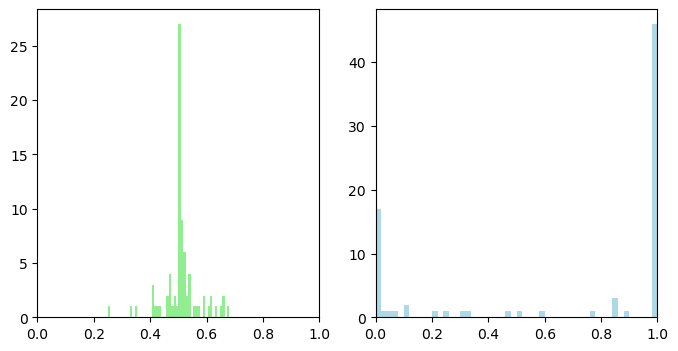

In [18]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))

ax[0].hist(c_prob_dist, label = 'cSVM probability distribution', color = 'lightgreen', bins = 50)
ax[1].hist(q_prob_dist, label = 'qSVM probability distribution', color = 'lightblue', bins = 50)

ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)

plt.show()

In [19]:
qSVM_accuracy.shape, cSVM_accuracy.shape

((4, 3, 4, 6), (7, 6))

## Variance

4 different values of R. For each other combination of the other 3 hyper-parameters -- B, K, gamma -- what is the variance of R as it varies. <br>
We end up with a 4x2x7 matrix with each element corresponding to the variance of the results for each different combination of B, K, gamma, which is then the variance over R. <br>
Would the variance of the variance the hyper-parameter be useful? <br>
Would the mean of the variance for each hyper-parameter be useful? No. <br>
Ok, basically both of them might be a better indication as to how important the parameters are. They can define a distribution which will be easier to understand than a list of numbers.
Where the variance appears would also be useful, but might be a little too in depth for the current level of analysis.
<br>
Note: cSVM nailed the classification, so it doesn't have any variance.

In [20]:
"""QUBO SVM"""

qSVM_variances = {'B': {}, 'K': {}, 'R': {}, 'gamma': {}}

for i, key in enumerate(list(qSVM_variances.keys())):
    auc = np.var(qSVM_auroc, axis = i)
    acc = np.var(qSVM_accuracy, axis = i)
    qSVM_variances[key]['auc'] = (np.mean(auc), np.var(auc))
    qSVM_variances[key]['acc'] = (np.mean(acc), np.var(acc))

In [21]:
[ (key, qSVM_variances[key]['auc']) for key in list(qSVM_variances.keys()) ]

[('B', (0.0005242187499999999, 1.7610453287760398e-07)),
 ('K', (0.0003965277777777779, 1.7509596836419768e-07)),
 ('R', (0.0005106770833333333, 2.3698289659288184e-07)),
 ('gamma', (0.0010688078703703708, 6.712346449277688e-07))]

## C, R, and Gamma

In [22]:
C_values = np.zeros((len(B_values), len(K_values)))

for i, B in enumerate(B_values):
    for j, K in enumerate(K_values):
       C_values[i, j] = np.sum([B ** k for k in range(K)])
C_values = C_values.flatten()
C_values

array([   3.,    7.,   15.,    4.,   13.,   40.,    6.,   31.,  156.,
         11.,  111., 1111.])

In [23]:
C_qSVM_accuracy = np.array([qSVM_accuracy[i, j, :, :] for i in range(len(B_values)) for j in range(len(K_values))])

In [24]:
C_qSVM_accuracy

array([[[0.63 , 0.625, 0.74 , 0.74 , 0.795, 0.76 ],
        [0.52 , 0.51 , 0.55 , 0.555, 0.6  , 0.58 ],
        [0.5  , 0.505, 0.5  , 0.545, 0.585, 0.64 ],
        [0.505, 0.5  , 0.51 , 0.535, 0.575, 0.59 ]],

       [[0.67 , 0.67 , 0.785, 0.785, 0.78 , 0.725],
        [0.56 , 0.555, 0.58 , 0.66 , 0.66 , 0.71 ],
        [0.505, 0.545, 0.63 , 0.63 , 0.685, 0.66 ],
        [0.525, 0.56 , 0.57 , 0.65 , 0.68 , 0.67 ]],

       [[0.755, 0.73 , 0.805, 0.79 , 0.79 , 0.755],
        [0.635, 0.655, 0.73 , 0.73 , 0.705, 0.72 ],
        [0.555, 0.62 , 0.665, 0.72 , 0.755, 0.715],
        [0.54 , 0.615, 0.6  , 0.695, 0.705, 0.7  ]],

       [[0.59 , 0.645, 0.695, 0.71 , 0.705, 0.735],
        [0.515, 0.515, 0.56 , 0.535, 0.62 , 0.58 ],
        [0.505, 0.505, 0.52 , 0.54 , 0.545, 0.59 ],
        [0.51 , 0.51 , 0.515, 0.545, 0.595, 0.605]],

       [[0.655, 0.685, 0.72 , 0.795, 0.745, 0.7  ],
        [0.53 , 0.59 , 0.61 , 0.665, 0.67 , 0.685],
        [0.505, 0.56 , 0.615, 0.72 , 0.69 , 0.68 ],
    

In [25]:
print(np.unravel_index(np.argmax(qSVM_accuracy), qSVM_accuracy.shape))
print(B_values[0], K_values[1], R_values[0], gamma_values[1])

(1, 2, 0, 3)
2 3 0 0.25
